In [31]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [32]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('./data/BTC-USD.csv')

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(value):
    if isinstance(value, str):
        return float(value.replace(',', ''))
    else:
        return float(value)

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Close'] = data['Close'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Close']

In [33]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [38]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 10s 123ms/step - loss: 0.0182 - val_loss: 0.0149
Epoch 2/100
20/20 [==============================] - 1s 62ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 3/100
20/20 [==============================] - 1s 61ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 4/100
20/20 [==============================] - 1s 62ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 5/100
20/20 [==============================] - 1s 62ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 6/100
20/20 [==============================] - 1s 61ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 7/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 8/100
20/20 [==============================] - 2s 98ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 9/100
20/20 [==============================] - 2s 106ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 10/100
20/20 [==============================] - 1s 61ms/step - loss: 0.0015 - val_loss: 0.0

In [40]:
# 10. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([ytest], dtype=np.float32))
y_pred_val_new = scaler.inverse_transform(y_pred_val.reshape(1, -1))
y_val_new = scaler.inverse_transform(np.array([yval], dtype=np.float32))


13/13 [==============================] - 0s 12ms/step


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_mda = calculate_mda(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 1599.4102
MAPE trên tập test là: 2.946847304701805 %
MDA trên tập test là: 46.96969696969697 %


In [42]:
# Tính toán RMSE, MAE và MAPE trên tập validation
val_score_rmse = np.sqrt(mean_squared_error(y_val_new, y_pred_val_new))
val_score_mape = mean_absolute_percentage_error(y_val_new, y_pred_val_new) * 100
val_score_mda = calculate_mda(y_val_new, y_pred_val_new)

print('RMSE trên tập validation là:', val_score_rmse)
print('MAPE trên tập validation là:', val_score_mape, '%')
print('MDA trên tập validation là:', val_score_mda, '%')

RMSE trên tập validation là: 673.41833
MAPE trên tập validation là: 1.7603181302547455 %
MDA trên tập validation là: 45.5919395465995 %


In [43]:
# 13. Dự báo 100 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<100):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 0.40600317 0.40376031 0.40544781 0.40603341 0.40476481 0.40406222
 0.41098933 0.40284736 0.40326273 0.40163693 0.40114004 0.40113582
 0.40329224 0.41238463 0.40921351 0.40716311 0.40666759 0.40695128
 0.40488303 0.40683436 0.40313321 0.39584939 0.36418102 0.35462104
 0.35534618 0.35679774 0.35578043 0.35434278 0.36056047 0.35637475
 0.35459168 0.35398224 0.35524496 0.35550078 0.38070271 0.37401646
 0.35278544 0.35075299 0.35181119 0.3533776  0.35093473 0.35043055
 0.35001479 0.35758448 0.3523841  0.35222902 0.35124268 0.34083429
 0.35126005 0.35739995 0.36223983 0.36331272 0.36268452 0.36215454
 0.36557586 0.3726773  0.37144756 0.36267444 0.36285998 0.36285722
 0.35784301 0.35849052 0.3572278  0.35933361 0.36973046 0.36802323
 0.36889678 0.38468775 0.37764648 0.37607946 0.38182197 0.3758608
 0.38411022 0.38445597 0.38393133 0.37846869 0.37547385 0.3674263
 0.365615   0.36725616 0.36724578 0.37187729 0.39301537 0.39140308
 0.39004437 0

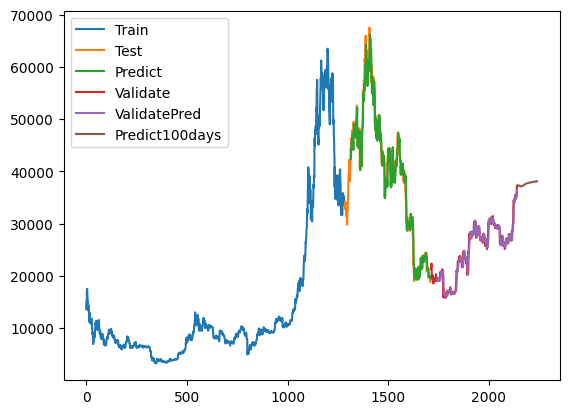

In [44]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+31, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(y_pred_val))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+99, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict100days'])
plt.show()